Current Directory: C:\Users\Lenovo\Untitled Folder\PrognosAI\Milestone_3
Files in directory: ['.ipynb_checkpoints', 'Milestone_3.ipynb', 'optimized.keras', 'optimized_lstm_scalers.pkl', 'README.md', 'scaler.pkl', 'sensor_data.csv', 'trained_LSTM_RUL_model.keras']
✅ X_train shape: (1128, 30, 3)
✅ y_train shape: (1128,)
✅ X_val shape: (282, 30, 3)
✅ y_val shape: (282,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            17408     
                                                                 
 dropout_2 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
              

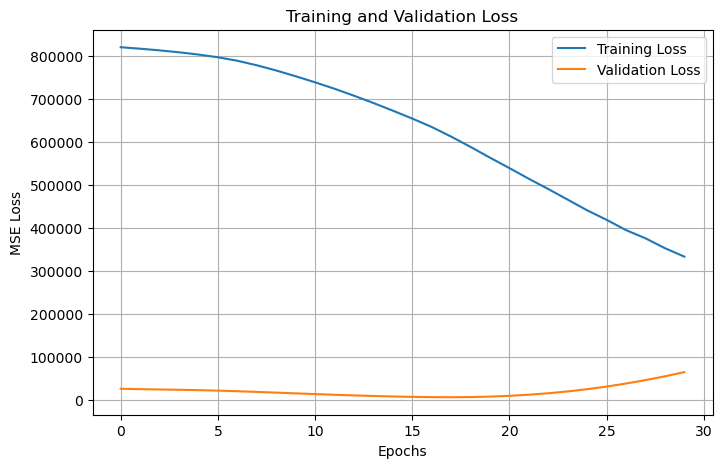

9/9 [==============================] - 2s 14ms/step
✅ Validation RMSE: 255.0665


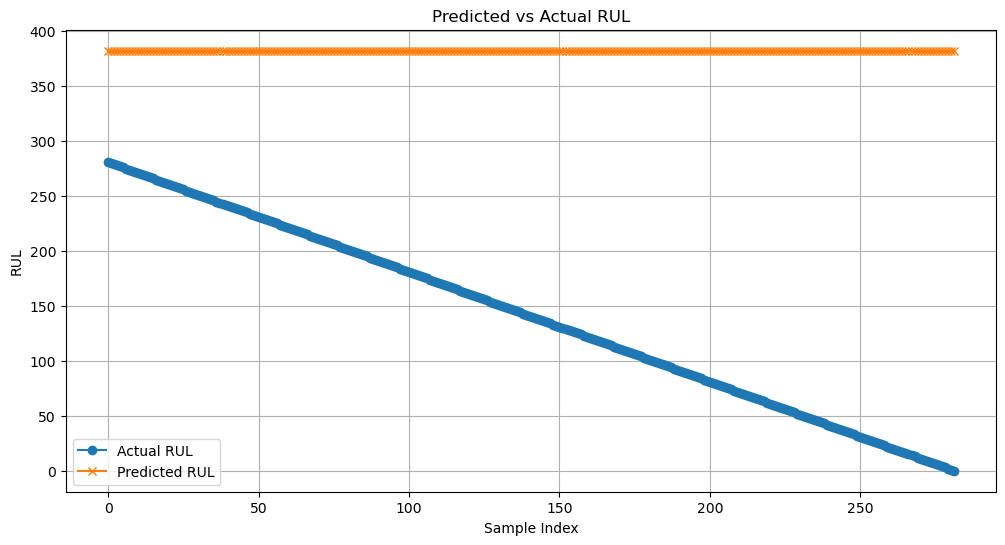

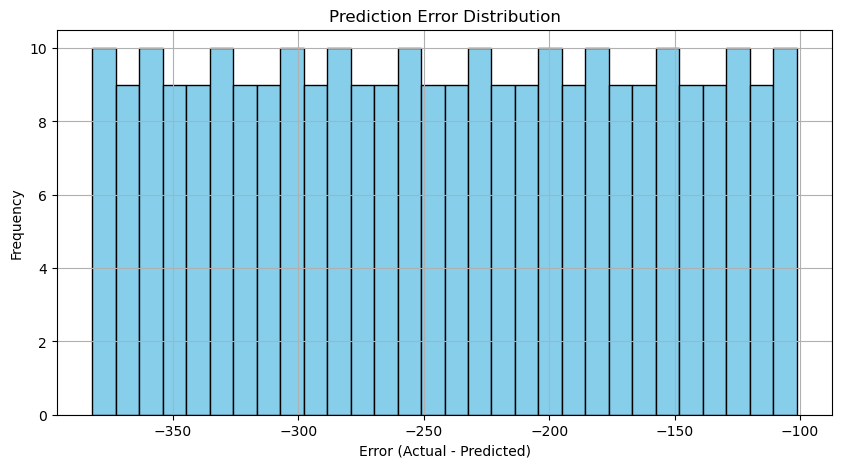

Mean Error: -241.72715889139377
Std Deviation of Error: 81.40585674926777
Top 5 samples with largest errors (index, actual, predicted, error):
277 4 382.22717 -378.2271728515625
278 3 382.22665 -379.2266540527344
279 2 382.226 -380.22601318359375
280 1 382.22668 -381.2266845703125
281 0 382.227 -382.22698974609375


In [3]:
# =====================================
# Milestone 2 + 3: LSTM Model Training & Evaluation for RUL Prediction
# =====================================

# ------------------------------
# Step 0: Import Libraries
# ------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pickle

# ------------------------------
# Step 0.1: Check Current Directory
# ------------------------------
print("Current Directory:", os.getcwd())
print("Files in directory:", os.listdir())

# ------------------------------
# Step 1: Load & Preprocess Sensor Data
# ------------------------------
df = pd.read_csv("sensor_data.csv")  # exact filename
df.fillna(method='ffill', inplace=True)

# Define sensor columns (adjust according to your CSV)
sensor_cols = ['SensorA', 'SensorB', 'SensorC']

# Scale sensor data
scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

# Save scaler for later use
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Compute Remaining Useful Life (RUL)
df['RUL'] = np.arange(len(df)-1, -1, -1)  # descending sequence

# ------------------------------
# Step 2: Create Rolling Window Sequences for LSTM
# ------------------------------
def create_rolling_windows(df, window_size=30):
    X, y = [], []
    for i in range(len(df)-window_size):
        X.append(df[sensor_cols].iloc[i:i+window_size].values)
        y.append(df['RUL'].iloc[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_rolling_windows(df, window_size)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print("✅ X_train shape:", X_train.shape)
print("✅ y_train shape:", y_train.shape)
print("✅ X_val shape:", X_val.shape)
print("✅ y_val shape:", y_val.shape)

# ------------------------------
# Step 3: Define LSTM Model
# ------------------------------
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Predict RUL
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ------------------------------
# Step 4: Train the Model
# ------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Save the trained model
model.save("trained_LSTM_RUL_model.keras")
print("✅ Model saved as trained_LSTM_RUL_model.keras")

# Save weights separately (optional)
model.save_weights("trained_LSTM_RUL_weights.h5")

# ------------------------------
# Step 5: Plot Training & Validation Loss
# ------------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Step 6: Model Evaluation (Milestone 3)
# ------------------------------
# Predictions on validation set
y_pred = model.predict(X_val)

# Flatten predictions and y_val to 1D
y_pred_flat = y_pred.flatten()
y_val_flat = y_val.flatten()

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_val_flat, y_pred_flat))
print(f"✅ Validation RMSE: {rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure(figsize=(12,6))
plt.plot(y_val_flat, label='Actual RUL', marker='o')
plt.plot(y_pred_flat, label='Predicted RUL', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Predicted vs Actual RUL')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Step 7: Error Analysis
# ------------------------------
errors = y_val_flat - y_pred_flat  # Flatten ensures 1D

# Histogram of prediction errors
plt.figure(figsize=(10,5))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title('Prediction Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Mean and Std of errors
print("Mean Error:", np.mean(errors))
print("Std Deviation of Error:", np.std(errors))

# Top 5 largest errors
num_largest_errors = 5
largest_errors_idx = np.argsort(np.abs(errors))[-num_largest_errors:]

print("Top 5 samples with largest errors (index, actual, predicted, error):")
for idx in largest_errors_idx:
    print(idx, y_val_flat[idx], y_pred_flat[idx], errors[idx])
